In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.shape

(790458, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [6]:
# check data range
print(df.Month_Invoiced.min())
print(df.Month_Invoiced.max())

2014-01-31
2017-12-31


In [7]:
# change Month_Invoiced to datetime
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])

In [8]:
df = df.set_index('Month_Invoiced').sort_values('Month_Invoiced')

In [9]:
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1013336,5013336,0.0,0.0
2014-01-31,1013335,5013335,0.0,0.0
2014-01-31,1013334,5013334,0.0,0.0
2014-01-31,1013333,5013333,1.0,5.0


In [10]:
# drop unrelevant columns
df = df.drop(columns=['Customer_Id','Invoice_Id','Subscription_Type'])

In [11]:
df.head(1)

,Amount
Month_Invoiced,
2014-01-31,0.0


1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [12]:
# resample data by month and aggregate with sum
df = df.resample("M").sum()
df.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [13]:
df.shape

(48, 1)

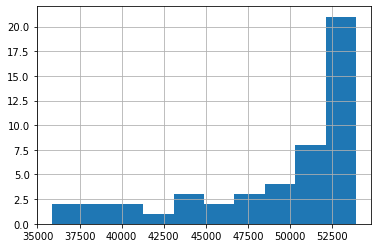

In [14]:
df.Amount.hist()

In [15]:
# split data
train_size = int(len(df.index)*.75)
train, test = df[:train_size], df[train_size:]

In [16]:
print(len(train))
print(len(test))

36
12


Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
Simple Average
Moving Average
Holt's Linear Trend Model
Based on previous year/month/etc., this is up to you.

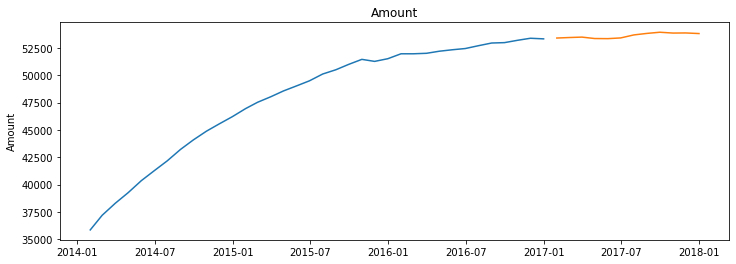

In [17]:
for col in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Last observed value
Make Predictions

In [18]:
def evaluate(target_var):
    # compute RMSE of predicted value vs. actual value
    mse = metrics.mean_squared_error(test[target_var], yhat_df[target_var])
    rmse = round(math.sqrt(mse),0)
    return rmse

In [19]:
def plot_and_eval(target_var):

    # plot actual values
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var],label = 'Train', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)

    # plot predicted values along with evaluation metric
    rmse = evaluate(target_var)
    plt.plot(yhat_df[target_var], linewidth = 1)
    plt.title(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))

    plt.show()

In [20]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)


### Forecast
- Last observed value
- Make Predictions

In [21]:
train.head(1)

,Amount
Month_Invoiced,
2014-01-31,35850.0


In [22]:
# amount
amount= train['Amount'][-1:][0]

yhat_df = pd.DataFrame({'Amount': [amount]},
                       index = test.index
                      )

yhat_df.head()

,Amount
Month_Invoiced,
2017-01-31,53320.0
2017-02-28,53320.0
2017-03-31,53320.0
2017-04-30,53320.0
2017-05-31,53320.0


Amount -- RMSE: 366


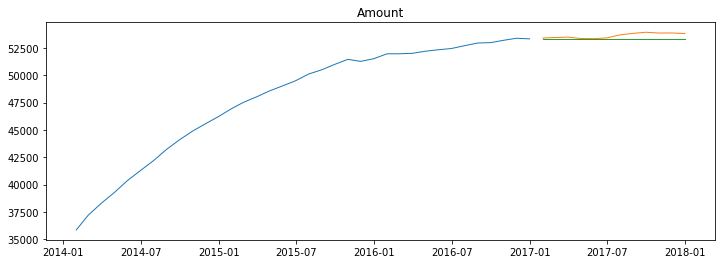

In [23]:
# Plot Actual vs. Predicted Values

for col in train.columns:
    plot_and_eval(col)

In [24]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

### Simple Average

In [25]:
# amount
amount= round(train['Amount'].mean(),1)
yhat_df = pd.DataFrame({'Amount': [amount]}, index = test.index)
yhat_df.head()

,Amount
Month_Invoiced,
2017-01-31,47916.7
2017-02-28,47916.7
2017-03-31,47916.7
2017-04-30,47916.7
2017-05-31,47916.7


Amount -- RMSE: 5700


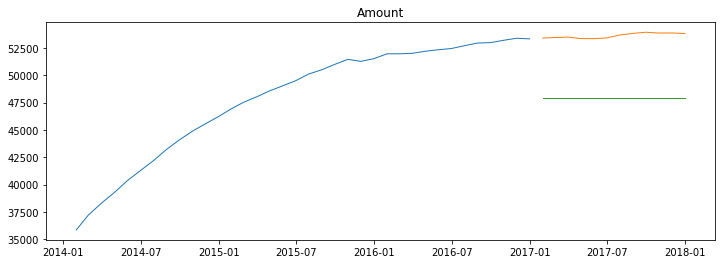

In [26]:
for col in train.columns:
    plot_and_eval(col)

In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)

### Moving Average

In [31]:
# compute a 30-day rolling mean and use the last value (.iloc[-1]) to forecast.
periods = 30
amount = round(train['Amount'].rolling(periods).mean().iloc[-1], 0)
yhat_df = pd.DataFrame({'Amount': [amount]}, index = test.index)

In [32]:
yhat_df.head(2)

,Amount
Month_Invoiced,
2017-01-31,49760.0
2017-02-28,49760.0


Amount -- RMSE: 3859


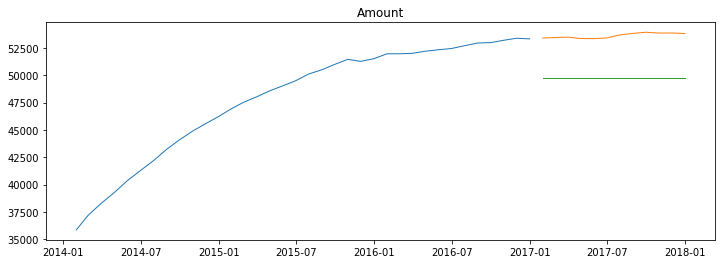

In [33]:
for col in train.columns:
    plot_and_eval(col)

In [34]:
for col in train.columns:
    eval_df = append_eval_df(model_type='moving_average', target_var = col)

### Holt's Linear Trend

Amount 



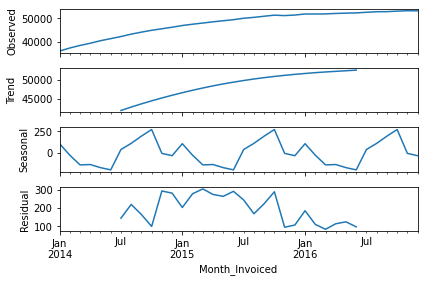

In [43]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [44]:
from statsmodels.tsa.api import Holt

col = 'Amount'

# create the model object
model = Holt(train[col])

# fit the model
model = model.fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)

# forecast, i.e. make predictions
yhat_items = model.predict(start = test.index[0], end = test.index[-1])

yhat_df[col] = round(yhat_items, 1)

- Plot Actual vs. Predicted Values

Amount -- RMSE: 1823


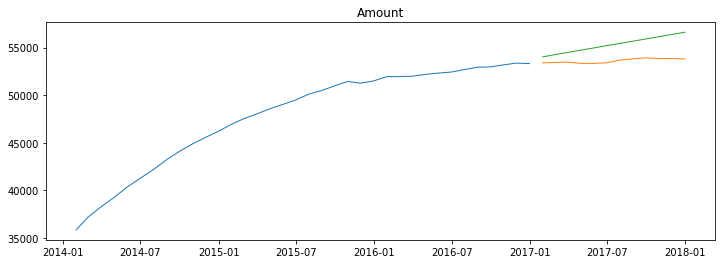

In [45]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_linear_trend', target_var = col)

### Predict Based on Previous Cycle

In [48]:
yhat_df = train['2017-01-01':'2017-12-30'] + train['2014-01-31':'2017-12-30'].diff(365).mean()

# set the date (index) to be represent the date for our predictions
yhat_df.index = pd.date_range('2016-04-20', periods=len(yhat_df))
